# Intro

This notebook is used to train classifiers to predict used memory, and then save the trained model along with the data it used. This includes a decision tree, a random forest, a gradient boosted decision tree model, and a logistic regressor.

# Notebook options

The grid_search parameter determines whether the notebook will execute a grid search for each model to find the best combination of hyperparameters, or whether the notebook will just use some pre-set parameters (which were found in previous grid searches).

The save_model parameter determines whether to save a model at the end (currently it saves the random forest model).

The training_mode parameter can either be 'normal', 'test', or 'final'.

In [17]:
grid_search = False
save_model = True
training_mode = 'final'

# Imports

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from hypopt import GridSearch
from datetime import datetime
from datetime import date
from preprocessing import get_df
from preprocessing import scale
from persistence import model_saver
from evaluation import score_model
from evaluation import print_feature_importances
from evaluation import plot_performance
from evaluation import plot_cm
from evaluation import print_cr
from evaluation import auc
import time

In [3]:
from sklearn.metrics import make_scorer

In [4]:
df = get_df()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   rinfo            50360 non-null  object             
 1   request_type     50360 non-null  object             
 2   job_start_at     50360 non-null  datetime64[ns]     
 3   job_end_at       50360 non-null  datetime64[ns]     
 4   req_mem          50360 non-null  float64            
 5   used_mem         50360 non-null  float64            
 6   dsnum            48150 non-null  object             
 7   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 8   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 9   dates_init       50360 non-null  bool               
 10  slat             32123 non-null  float64            
 11  nlat             32123 non-null  float64            
 12  wlon             32140 non-null  float64            
 13  elon    

In [12]:
categories_dict = {0:60, 1:120, 2:300, 
                   3:600, 4:1800, 5:3600,
                   6:14400, 7:43200}

num_classes = len(categories_dict)
bin_sizes = [df[df.wall_time < categories_dict[0]].shape[0]]
for i in range(1, num_classes):
    current_bin_size = df[(df.wall_time >= categories_dict[i-1])
                        & (df.wall_time < categories_dict[i])].shape[0]
    bin_sizes.append(current_bin_size)

In [10]:
def print_time_categories():
    print(f"0: < {categories_dict[0]}s ({bin_sizes[0]} entries)")
    for i in range(1, num_classes):
        print(f"{i}: >= {categories_dict[i-1]}s"
              + f" and < {categories_dict[i]}s"
              + f" ({bin_sizes[i]} entries)")

In [11]:
print_time_categories()

0: < 60s (7371 entries)
1: >= 60s and < 120s (10720 entries)
2: >= 120s and < 300s (8174 entries)
3: >= 300s and < 600s (5519 entries)
4: >= 600s and < 1800s (7726 entries)
5: >= 1800s and < 3600s (4005 entries)
6: >= 3600s and < 14400s (5521 entries)
7: >= 14400s and < 43200s (1070 entries)


In [13]:
def time_category(row):
    time = min(row['wall_time'], 43199)
    if time < categories_dict[0]:
        return 0
    for i in range(1, num_classes):
        if time >= categories_dict[i-1] and time < categories_dict[i]:
            return i
    return None

In [14]:
df['time_category'] = df.apply(lambda row: time_category(row), axis=1)

In [16]:
df[['wall_time', 'time_category']].sample(5)

,wall_time,time_category
6416301,14177.0,6
6607730,878.0,4
6520280,278.0,2
6478814,111.0,1
6432967,59.0,0


In [18]:
df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['wall_time', 'time_category']

X = df[X_features]
y = df[y_features]

## Train/validation/test split

In [19]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

In [20]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test, y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)

In [21]:
y_train = np.ravel(y_train_full['time_category'])
y_val = np.ravel(y_val_full['time_category'])
y_test = np.ravel(y_test_full['time_category'])

## Scaling

In [22]:
X_train_norm, X_val_norm, X_test_norm = \
    scale(X_train, X_val, X_test)

In [23]:
def balanced_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = n_samples / (num_classes * (np.bincount(y_train)))

    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

balanced_scorer = make_scorer(score_func=balanced_score,
                              greater_is_better=True)

In [24]:
def custom_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = np.array([(i+1)**2 for i in range(num_classes)])
    #print(class_weights)
    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

custom_scorer = make_scorer(score_func=custom_score,
                              greater_is_better=True)

In [25]:
class_weights = {i:float((i+1)**2) for i in range(num_classes)}
print(class_weights)

{0: 1.0, 1: 4.0, 2: 9.0, 3: 16.0, 4: 25.0, 5: 36.0, 6: 49.0, 7: 64.0}


## Trees, Forest, Gradient Boosts

### Tree

In [19]:
if grid_search:
    tree_param_grid = {'random_state':[3], 'max_depth':range(2,20),
                       'min_samples_split':range(2,8),
                       'class_weight':['balanced']}
    tree_gs = GridSearch(model=DecisionTreeClassifier(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, y_train, X_val_norm, y_val, scoring=balanced_scorer)
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_

else:
    tree = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=19, random_state=3)
    tree.fit(X_train_norm, y_train)

### Forest

In [26]:
if grid_search:
    start = time.time()
    forest_param_grid = {'random_state':[3],
                               'max_depth':range(2,20),
                               'min_samples_split':range(5,35,5),
                               'n_estimators':range(50,250,25),
                               'n_jobs':[20]}
    forest_gs = GridSearch(model=RandomForestClassifier(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
else:
    forest = RandomForestClassifier(class_weight='balanced',
                                      max_depth=19,
                                      min_samples_split=5,
                                      n_estimators=225,
                                      random_state=3)
    forest.fit(X_train_norm, y_train)

In [27]:
if training_mode == 'test':
    new_X_train = np.concatenate((X_train_norm, X_val_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full])['time_category'])
    forest.fit(new_X_train, new_y_train)
elif training_mode == 'final':
    new_X_train = np.concatenate((X_train_norm,
                                  X_val_norm,
                                  X_test_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full,
                                      y_test_full])['time_category'])
    forest.fit(new_X_train, new_y_train)

### Gradient boosted trees

In [22]:
if grid_search:
    gboost_param_grid = {'random_state':[3],
                               'max_depth':range(2,15),
                               'n_estimators':[50,100,150,200]}
    gboost_gs = GridSearch(model=GradientBoostingClassifier(), 
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(class_gboost_gs.best_params)
    class_gboost = class_gboost_gs.best_estimator_
else:
    gboost = GradientBoostingClassifier(random_state=3,
                                        max_depth=14,
                                        n_estimators=150)
    #gboost.fit(X_train_norm, y_train)

In [23]:
if grid_search:
    hist_gboost_param_grid = {'random_state':[3],
                               'max_depth':range(2,20),
                               'min_samples_leaf':range(15,35,5),
                               'max_iter':[50,100,150]}
    hist_gboost_gs = GridSearch(model=HistGradientBoostingClassifier(), 
                                param_grid=hist_gboost_param_grid,
                                parallelize=False)
    hist_gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(hist_gboost_gs.best_params)
    hist_gboost = hist_gboost_gs.best_estimator_
else:
    hist_gboost = HistGradientBoostingClassifier(random_state=3,
                                        max_depth=16,
                                        max_iter=150,
                                        min_samples_leaf=15)
    #gboost.fit(X_train_norm, y_train)

{'max_depth': 16, 'max_iter': 150, 'min_samples_leaf': 15, 'random_state': 3}


## Linear regressors

In [23]:
logist = LogisticRegression(max_iter=1000, class_weight='balanced')
logist.fit(X_train_norm, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [32]:
notes = "Time class forest, filling missing lat/lon with max value. " \
         + "Trained on train + val + test data. " \
         + "Grid searched on Casper Batch job. " \
         + "X values NOT scaled. " \
         + "Uses balanced class weights."

In [33]:
if save_model:
    ms = model_saver('time_forest_final', notes,
                     forest, df, 
                     categories_dict,
                     X_features,
                     X_train, y_train_full,
                     X_val, y_val_full,
                     X_test, y_test_full)
    ms.save()

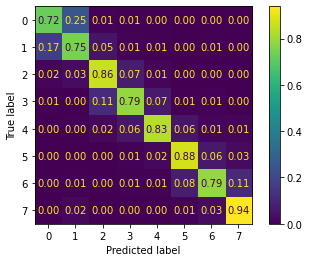

In [30]:
plot_cm(X_val=X_val_norm, y_val=y_val, model=forest)

In [34]:
print_cr(X_val_norm, y_val, forest)

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1846
           1       0.80      0.76      0.78      2659
           2       0.83      0.87      0.85      2059
           3       0.80      0.78      0.79      1385
           4       0.90      0.82      0.86      1920
           5       0.76      0.89      0.82       975
           6       0.90      0.79      0.84      1405
           7       0.56      0.96      0.70       305

    accuracy                           0.81     12554
   macro avg       0.79      0.83      0.80     12554
weighted avg       0.81      0.81      0.81     12554

